<a href="https://colab.research.google.com/github/cristiancs/TMMC-PRACTICA-1/blob/master/LABORATORIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

In [0]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

%load_ext nvcc_plugin


In [0]:
!nvcc --version

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [8]:
from google.colab import files
uploaded = files.upload()



Saving data.txt.zip to data.txt.zip


In [16]:
!unzip "data.txt.zip"

Archive:  data.txt.zip
  inflating: data.txt                
   creating: __MACOSX/
  inflating: __MACOSX/._data.txt     


# AoS

In [80]:
%%cu
#include <iostream>
#include <fstream>
#include <string>
#include <stdio.h>
#include <cstring>

#include <stdlib.h>
using namespace std;


int calcular_materia(int* data, int M, int N) {
    int suma = 0;
    for (int i = 0; i < M*N; ++i) {
	    suma+= data[i*4];
        suma+= data[i*4+1];
        suma+= data[i*4+2];
        suma+= data[i*4+3];
	}
   return suma;
}

__global__ void colision(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	
	if(tId < N * M) {
        int top, bottom, left, right;
        right = data[tId*4+0];
        top   = data[tId*4+1];
        left  = data[tId*4+2];
        bottom  = data[tId*4+3];
        // Hay Colision
        if((right+top+left+bottom) == 2 ) {
            if((top + bottom) == 2) {
                left = 1;
                right = 1;
                top = 0;
                bottom = 0;
            } else if((left + right) == 2) {
                left = 0;
                right = 0;
                top = 1;
                bottom = 1;
            }
        }
        salida[tId*4+0] = right;
        salida[tId*4+1] = top;
        salida[tId*4+2] = left;
        salida[tId*4+3] = bottom;
	}
}


__global__ void stream(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	
	if(tId < N * M) {
        int top, bottom, left, right, x, y;
        right = data[tId*4+0];
        top   = data[tId*4+1];
        left  = data[tId*4+2];
        bottom  = data[tId*4+3];

        x = tId%M;
        y = tId/M;
        
        int tId_next_top = y-1 == -1 ? N*M - (M-x) : tId - M ;
        int tId_next_bottom = y+1 == N ? x : tId + M;
        int tId_next_left = x-1 == -1 ? tId + M - 1 : tId - 1 ;
        int tId_next_right = x+1 == M ? tId - M + 1 : tId + 1 ;


        salida[tId_next_right*4+0] = right;
        salida[tId_next_top*4+1] = top;
        salida[tId_next_left*4+2] = left;
        salida[tId_next_bottom*4+3] = bottom;
	}
}


int *CalcularAoS(string filename, int *M, int *N)
{
    char cstr[filename.size() + 1];
    strcpy(cstr, filename.c_str());
    FILE *in = fopen(cstr, "r");
    fscanf(in, "%d %d", M, N);

    int *AoS = new int[4 * *M * *N];

    for (int i = 0; i < 4; i++)
    {
        for (int j = 0; j < *M * *N; j++)
        {
            fscanf(in, "%d", &AoS[i + (j * 4)]);
        }
    }
    
    fclose(in);
    return AoS;
}

int main(int argc, char const *argv[])
{

    int M, N;
    int *AoS = CalcularAoS("initial.txt", &M, &N);
 
    cudaEvent_t ct1, ct2;
    int block_size = 256;
    int grid_size = (int) ceil( (float) M * N / block_size);
 
    int* data_gpu, *salida_gpu;
    float dt;
    FILE * pSalida;
    cudaMalloc(&data_gpu, sizeof(int) * N * M * 4);
    cudaMalloc(&salida_gpu, sizeof(int) * N * M * 4);
    cudaMemcpy(data_gpu, AoS, sizeof(int) * N * M * 4, cudaMemcpyHostToDevice);

    cout << calcular_materia(AoS, M, N) << endl;
    cudaEventCreate(&ct1);
	cudaEventCreate(&ct2);
	cudaEventRecord(ct1);
    int generar_grafico = 0;

    for(int movement = 0; movement < 3; movement++) {
        colision<<<grid_size, block_size>>>(data_gpu, salida_gpu, M, N);
        cudaDeviceSynchronize();
        stream<<<grid_size, block_size>>>(salida_gpu, data_gpu, M, N);
        cudaDeviceSynchronize();
        if(generar_grafico) {
            cudaMemcpy(AoS, data_gpu, sizeof(int) * N * M * 4, cudaMemcpyDeviceToHost);
            
            char filename[64];
            sprintf (filename, "gpu_salida_aos_%d.txt", movement);


            pSalida = fopen (filename,"w");
            fprintf(pSalida, "%d %d\n", M, N);
            for(int i = 0; i < 4; ++i) {
                for (int j = 0; j < N*M; ++j) {
                        if(j == N*M - 1) {
                            fprintf(pSalida, "%d\n", AoS[i + (j * 4)]);
                        } else {
                            fprintf(pSalida, "%d ", AoS[i + (j * 4)]);
                        }
                    
                }
            }
            fclose(pSalida);
        }
    }
	
	cudaEventRecord(ct2);
	cudaEventSynchronize(ct2);
	cudaEventElapsedTime(&dt, ct1, ct2);

    cout << "Tiempo: " << dt << "[ms]" << '\n';
    
    
	
    
    return 0;
}

56
Tiempo: 11.3911[ms]



# SoA

In [98]:
%%cu
#include <iostream>
#include <fstream>
#include <string>
#include <stdio.h>
#include <cstring>

#include <stdlib.h>
using namespace std;


int calcular_materia(int* data, int M, int N) {
    int suma = 0;
    for (int i = 0; i < M*N; ++i) {
	    suma+= data[i];
      suma+= data[i+(M*N*1)];
      suma+= data[i+(M*N*2)];
      suma+= data[i+(M*N*3)];
	}
   return suma;
}

__global__ void colision(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	
	if(tId < N * M) {
        int top, bottom, left, right;
        right = data[tId+(M*N*0)];
        top   = data[tId+(M*N*1)];
        left  = data[tId+(M*N*2)];
        bottom  = data[tId+(M*N*3)];
        // Hay Colision
        if((right+top+left+bottom) == 2 ) {
            if((top + bottom) == 2) {

                left = 1;
                right = 1;
                top = 0;
                bottom = 0;
            } else if((left + right) == 2) {
                left = 0;
                right = 0;
                top = 1;
                bottom = 1;
            }
        }
        salida[tId+(M*N*0)] = right;
        salida[tId+(M*N*1)] = top;
        salida[tId+(M*N*2)] = left;
        salida[tId+(M*N*3)] = bottom;
	}
}


__global__ void stream(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	if(tId < N * M) {
        int top, bottom, left, right, x, y;
        right = data[tId+(M*N*0)];
        top   = data[tId+(M*N*1)];
        left  = data[tId+(M*N*2)];
        bottom  = data[tId+(M*N*3)];

        x = tId%M;
        y = tId/M;
        
        int tId_next_top = y-1 == -1 ? N*M - (M-x) : tId - M ;
        int tId_next_bottom = y+1 == N ? x : tId + M;
        int tId_next_left = x-1 == -1 ? tId + M - 1 : tId - 1 ;
        int tId_next_right = x+1 == M ? tId - M + 1 : tId + 1 ;


        salida[tId_next_right+(M*N*0)] = right;
        salida[tId_next_top+(M*N*1)] = top;
        salida[tId_next_left+(M*N*2)] = left;
        salida[tId_next_bottom+(M*N*3)] = bottom;
        
	}
}

int* CalcularSoA(string filename, int *N, int *M) {
    char cstr[filename.size() + 1];
    strcpy(cstr, filename.c_str());
    FILE *in = fopen(cstr, "r");
    fscanf(in, "%d %d", M, N);

    int *SoA = new int[4 * *M * *N];
    for (int i = 0; i < 4; i++)
    {
        for (int j = 0; j < *M * *N; ++j)
        {
            fscanf(in, "%d", &SoA[(i * *M * *N) + j]);
        }
    }
    fclose(in);
    return SoA;
} 

int main(int argc, char const *argv[])
{

    int M, N;
    int *SoA = CalcularSoA("initial.txt", &M, &N);
 
    cudaEvent_t ct1, ct2;
    int block_size = 256;
    int grid_size = (int) ceil( (float) M * N / block_size);
 
    int* data_gpu, *salida_gpu;
    float dt;
    cudaMalloc(&data_gpu, sizeof(int) * N * M * 4);
    cudaMalloc(&salida_gpu, sizeof(int) * N * M * 4);
    cudaMemcpy(data_gpu, SoA, sizeof(int) * N * M * 4, cudaMemcpyHostToDevice);

    cout << calcular_materia(SoA, M, N) << endl;
    cudaEventCreate(&ct1);
	cudaEventCreate(&ct2);
	cudaEventRecord(ct1);
    int generar_grafico = 1;
    FILE * pSalida;
    for(int movement = 0; movement < 3; movement++) {
        colision<<<grid_size, block_size>>>(data_gpu, salida_gpu, M, N);
        cudaDeviceSynchronize();
        stream<<<grid_size, block_size>>>(salida_gpu, data_gpu, M, N);
        cudaDeviceSynchronize();

        if(generar_grafico) {
            cudaMemcpy(SoA, data_gpu, sizeof(int) * N * M * 4, cudaMemcpyDeviceToHost);
            char filename[64];
            sprintf (filename, "gpu_salida_soa_%d.txt", movement);


            pSalida = fopen (filename,"w");
            fprintf(pSalida, "%d %d\n", M, N);
            for(int i = 0; i < 4; ++i) {
                for (int j = 0; j < N*M; ++j) {
                        if(j == N*M - 1) {
                            fprintf(pSalida, "%d\n", SoA[(i * M * N) + j]);
                        } else {
                            fprintf(pSalida, "%d ", SoA[(i * M * N) + j]);
                        }
                    
                }
            }
            fclose(pSalida);
        }

    }
	

	cudaEventRecord(ct2);
	cudaEventSynchronize(ct2);
	cudaEventElapsedTime(&dt, ct1, ct2);

    cout << "Tiempo: " << dt << "[ms]" << '\n';
 
    
    return 0;
}

56
Tiempo: 10.5701[ms]



# Parte B

In [0]:
m%%cu
#include <iostream>
#include <fstream>
#include <string>
#include <stdio.h>
#include <cstring>

#include <stdlib.h>
using namespace std;


int calcular_materia(int* data, int M, int N) {
    int suma = 0, top, bottom, left, right;
    for (int i = 0; i < M*N; ++i) {
        right = (data[i] & ( 1 << 0)) >> 0;
        top   = (data[i] & ( 1 << 1 )) >> 1;
        left  = (data[i] & ( 1 << 2 )) >> 2;
        bottom  = (data[i] & ( 1 << 3)) >> 3;
        
        suma+=right+top+left+bottom;
        
	}
   return suma;
}
__device__ int atomicSet(int* address, int val){
    int old = *address, assumed;
    do{
        assumed = old;
        old = atomicCAS(address, assumed, val);
    } while(assumed != old);
    return old;
}

__global__  void colision(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	
	if(tId < N * M) {
        int top, bottom, left, right, toSave=data[tId];
        right = (toSave & ( 1 << 0)) >> 0;
        top   = (toSave & ( 1 << 1 )) >> 1;
        left  = (toSave & ( 1 << 2 )) >> 2;
        bottom  = (toSave & ( 1 << 3)) >> 3;

        // Hay Colision
        if((right+top+left+bottom) == 2 ) {
            if((top + bottom) == 2) {
                toSave = 0b0101;
            } else if((left + right) == 2) {
                toSave = 0b1010;
            }
        }
        salida[tId] = toSave;
	}
}


__global__ void stream(int* data,  int* salida, int M, int N) {
	int tId = threadIdx.x + blockIdx.x * blockDim.x;

	
	if(tId < N * M) {
        int top_vecino, bottom_vecino, left_vecino, right_vecino, x, y;


        right = (lectura & 0b1) > 0;
        top   = (lectura & 0b10) > 0;
        left  = (lectura & 0b100) > 0;
        bottom  = (lectura & 0b1000) > 0;

        x = tId%M;
        y = tId/M;
        
        int tId_next_top = y-1 == 0 ? N*M - (M-x) : tId - M ;
        int tId_next_bottom = y+1 == N ? x : tId + M;
        int tId_next_left = x-1 == -1 ? tId + M - 1 : tId - 1 ;
        int tId_next_right = x+1 == M ? tId - M + 1 : tId + 1 ;

        right_vecino = data[tId_next_left];
        if(right_vecino == 1) {
            atomicSet(&salida[tId], data[tId]-1);
        }
        if(top == 1) {
            atomicSub(&salida[tId], 2);
            atomicAdd(&salida[tId_next_top], 2);
        }
        if(left == 1) {
            // El problema es que esta hebra hace 0
            // pero la siguiente hebra si quiere mover a esta posición debe dejarla en 1
            // por tanto dependiendo de quien trabaje primero
            // va a quedar con 0 o 1
            atomicSub(&salida[tId], 4);
            atomicAdd(&salida[tId_next_left], 4);
        }
        if(bottom == 1) {
            atomicSub(&salida[tId], 8);
            atomicAdd(&salida[tId_next_bottom], 8);
        }
	}
}


int *Read2Binary(string filename, int *M, int *N)
{
    char cstr[filename.size() + 1];
    strcpy(cstr, filename.c_str());
    FILE *in = fopen(cstr, "r");
    fscanf(in, "%d %d", M, N);
    int *data = new int[*M * *N];
    int suma = 0;
    for (int i = 0; i < 4; i++)
    {
        int lectura;
        for (int j = 0; j < *M * *N; j++)
        {
            fscanf(in, "%d", &lectura );
            if(lectura == 1) {
                suma+=1;
            }
            lectura = lectura << i;
           
            data[j] =  data[j] | lectura;
        }
    }
    cout << "Iones segun lectura: " << suma << endl;
    fclose(in);
    return data;
}

int main(int argc, char const *argv[])
{

    int M, N;
    int *data = Read2Binary("data.txt", &M, &N);
 
    cudaEvent_t ct1, ct2;
    int block_size = 256;
    int grid_size = (int) ceil( (float) M * N / block_size);
 
    int* data_gpu, *salida_gpu;
    float dt;
    cudaMalloc(&data_gpu, sizeof(int) * N * M );
    cudaMalloc(&salida_gpu, sizeof(int) * N * M );
    cudaMemcpy(data_gpu, data, sizeof(int) * N * M, cudaMemcpyHostToDevice);

    cout << calcular_materia(data, M, N) << endl;
    cudaEventCreate(&ct1);
	cudaEventCreate(&ct2);
	cudaEventRecord(ct1);

    for(int i = 0; i < 100; i++) {
        colision<<<grid_size, block_size>>>(data_gpu, salida_gpu, M, N);
        cudaDeviceSynchronize();
        stream<<<grid_size, block_size>>>(salida_gpu, data_gpu, M, N);
        cudaDeviceSynchronize();
        cudaMemcpy(data, data_gpu, sizeof(int) * N * M, cudaMemcpyDeviceToHost);
        cout << "a stream: "  << calcular_materia(data, M, N) << endl;
    }
	

	cudaEventRecord(ct2);
	cudaEventSynchronize(ct2);
	cudaEventElapsedTime(&dt, ct1, ct2);

    cout << "Tiempo: " << dt << "[ms]" << '\n';
 
    
    return 0;
}

Iones segun lectura: 5999701
5999701
a stream: 5998845
a stream: 5998012
a stream: 5997098
a stream: 5996477
a stream: 5997189
a stream: 5998415
a stream: 5998960
a stream: 5998445
a stream: 5998005
a stream: 6000800
a stream: 5999394
a stream: 5997222
a stream: 5997631
a stream: 5998377
a stream: 5997980
a stream: 5998858
a stream: 5997953
a stream: 5997805
a stream: 5998746
a stream: 5997911
a stream: 5996732
a stream: 5996467
a stream: 5997624
a stream: 5996921
a stream: 5995412
a stream: 5997601
a stream: 5997581
a stream: 5997362
a stream: 5997457
a stream: 5997077
a stream: 5996087
a stream: 5997391
a stream: 5995815
a stream: 5995192
a stream: 5996043
a stream: 5997369
a stream: 5997216
a stream: 5999857
a stream: 5999053
a stream: 5999669
a stream: 5999387
a stream: 5997445
a stream: 5995851
a stream: 5996365
a stream: 5996206
a stream: 5997313
a stream: 5995457
a stream: 5993944
a stream: 5994263
a stream: 5993223
a stream: 5992864
a stream: 5991253
a stream: 5991233
a stream:

# Pruebas

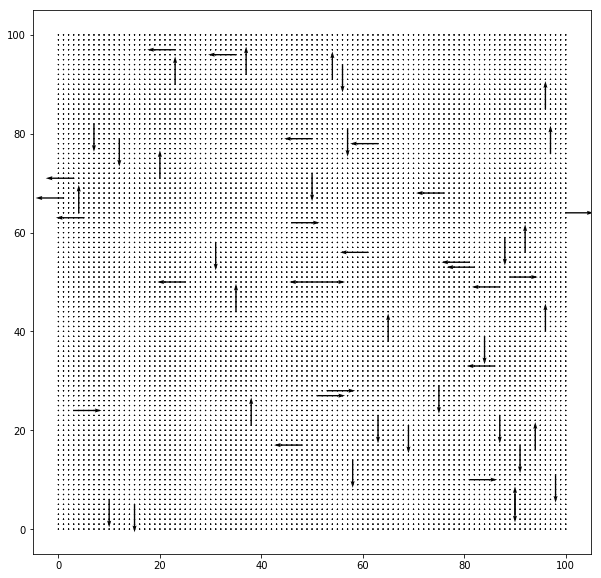

In [99]:
# Lectura de archivo (resultados)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


name = 'gpu_salida_soa_0.txt' # Cambiar por su archivo de salida (si genera varios tiempos considere utilizar un for)
a = open(name)
N,M = map(int,a.readline().strip().split())
f0x = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f1y = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f2x = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f3y = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
a.close()
f0y = np.zeros((N,M))
f1x = np.zeros((N,M))
f2y = np.zeros((N,M))
f3x = np.zeros((N,M))

plt.figure(figsize=(10,10))
plt.quiver(x,y,f0x,f0y,scale=20)
plt.quiver(x,y,f1x,f1y,scale=20)
plt.quiver(x,y,f2x,f2y,scale=20)
plt.quiver(x,y,f3x,f3y,scale=20)


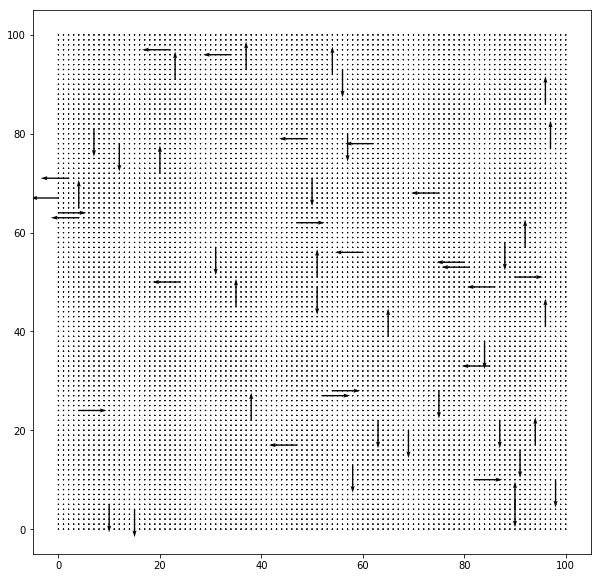

In [100]:
# Lectura de archivo (resultados)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,M-1,M)
y = np.linspace(0,N-1,N)
x,y = np.meshgrid(x,y)


name = 'gpu_salida_soa_1.txt' # Cambiar por su archivo de salida (si genera varios tiempos considere utilizar un for)
a = open(name)
N,M = map(int,a.readline().strip().split())
f0x = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f1y = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f2x = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f3y = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
a.close()
f0y = np.zeros((N,M))
f1x = np.zeros((N,M))
f2y = np.zeros((N,M))
f3x = np.zeros((N,M))


plt.figure(figsize=(10,10))
plt.quiver(x,y,f0x,f0y,scale=20)
plt.quiver(x,y,f1x,f1y,scale=20)
plt.quiver(x,y,f2x,f2y,scale=20)
plt.quiver(x,y,f3x,f3y,scale=20)


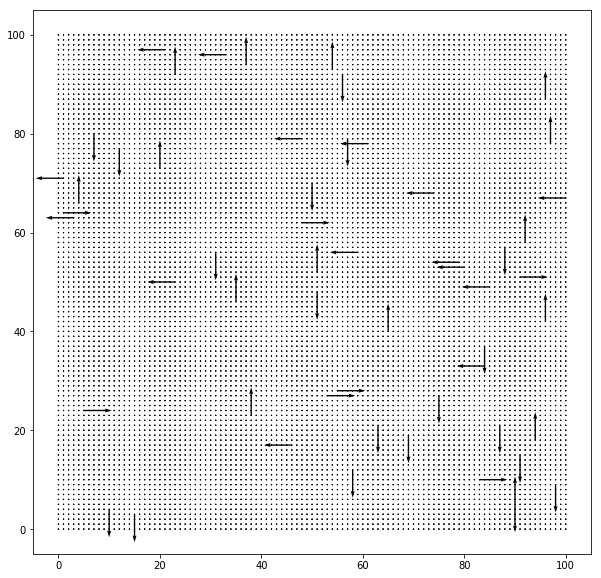

In [101]:
# Lectura de archivo (resultados)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,M-1,M)
y = np.linspace(0,N-1,N)
x,y = np.meshgrid(x,y)


name = 'gpu_salida_aos_2.txt' # Cambiar por su archivo de salida (si genera varios tiempos considere utilizar un for)
a = open(name)
N,M = map(int,a.readline().strip().split())
f0x = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f1y = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f2x = -np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
f3y = np.array(list(map(int,a.readline().strip().split()))).reshape((N,M))
a.close()
f0y = np.zeros((N,M))
f1x = np.zeros((N,M))
f2y = np.zeros((N,M))
f3x = np.zeros((N,M))


plt.figure(figsize=(10,10))
plt.quiver(x,y,f0x,f0y,scale=20)
plt.quiver(x,y,f1x,f1y,scale=20)
plt.quiver(x,y,f2x,f2y,scale=20)
plt.quiver(x,y,f3x,f3y,scale=20)
